# LIME
## Local Interpretable Model-agnostic Explanations

In this notebook we will see the application of LIME to two different kinds of tasks: regression and classification.
Both tasks are performed on tabular data, so expect to see the LimeTabularExplainer class in action.

The notebook is organised into two main parts (one for task) and each part is further divided into subsections:

0. [**imports**](#imports)<br>
1. [**Regression**](#regression)<br>
    2. [**dataset description and analysis**](#regression-dataset)<br>
    3. [**training and evaluation**](#regression-training)<br>
    4. [**explanation**](#regression-explanation)<br>
2. [**Classification**](#classification)<br>
    1. [**dataset description and analysis**](#classification-dataset)<br>
    2. [**training and evaluation**](#classification-training)<br>
    3. [**explanation**](#classification-explanation)<br>

Note: Internet connection is required to download the dataset.
If the files of the Census Income dataset are in folder `data` Internet connection is not required.

<a id='imports'></a>
## Imports and utility functions

Some necessary imports:
- __pandas__ for data presentation and statistics
- __sklearn__ for data retrival and manipulation
- __numpy__ for reproducibility
- __matplotlib__ for data visualization
- __lime__ for interpretability
- __os__ to import utility functions

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from numpy.random import seed
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import os

os.getcwd()
from data import CensusIncome, PATH as DATA_PATH

In [2]:
SEED = 0
TEST_SIZE = 0.5
INDEX = 100

<a id='regression'></a>
## Regression

<a id='regression-dataset'></a>
## Dataset description and analysis

The dataset used is the California Housing dataset.
It contains 20,640 samples and 8 features.
The target is the median house value for California districts.
The features are:
- MedInc median income in block
- HouseAge median house age in block
- AveRooms average number of rooms
- AveBedrms average number of bedrooms
- Population block population
- AveOccup average house occupancy
- Latitude house block latitude
- Longitude house block longitude

The target is the median house value in block.

In [3]:
housing = fetch_california_housing()
dataset = pd.concat([pd.DataFrame(housing.data, columns=housing.feature_names), pd.DataFrame(housing.target, columns=['target'])], axis=1)
dataset

# dataset = pd.read_csv(DATA_PATH / 'california_housing_dataset.csv')  # Run this if there is no internet connection

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


Splitting the dataset into train and test sets.

In [4]:
train, test = train_test_split(dataset, test_size=TEST_SIZE, random_state=SEED)
train_x, train_y = train.iloc[:, :-1].to_numpy(), train.iloc[:, -1].to_numpy()
test_x, test_y = test.iloc[:, :-1].to_numpy(), test.iloc[:, -1].to_numpy()

In [5]:
train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000
mean,3.870005,28.659109,5.412961,1.094045,1428.653876,3.027517,35.631556,-119.574194,2.071104
std,1.882240,12.647918,2.327456,0.459424,1161.103443,6.420769,2.137086,2.008333,1.150612
min,0.499900,1.000000,0.888889,0.333333,3.000000,0.750000,32.560000,-124.350000,0.149990
25%,2.586500,18.000000,4.454396,1.007055,783.000000,2.421734,33.930000,-121.810000,1.200000
50%,3.550350,29.000000,5.223049,1.050000,1167.000000,2.813071,34.250000,-118.480000,1.809000
75%,4.723900,37.000000,6.021631,1.100894,1722.000000,3.275000,37.720000,-118.000000,2.636000
max,15.000100,52.000000,132.533333,34.066667,35682.000000,599.714286,41.950000,-114.310000,5.000010


In [12]:
normalised_train=(train-train.min())/(train.max()-train.min())
normalised_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000
mean,0.232418,0.542335,0.034366,0.022551,0.039958,0.003802,0.327109,0.475678,0.396104
std,0.129808,0.247998,0.017680,0.013619,0.032543,0.010720,0.227592,0.200033,0.237239
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.143901,0.333333,0.027084,0.019972,0.021862,0.002791,0.145900,0.252988,0.216496
50%,0.210373,0.549020,0.032923,0.021245,0.032624,0.003444,0.179979,0.584661,0.342063
75%,0.291306,0.705882,0.038989,0.022754,0.048180,0.004216,0.549521,0.632470,0.512577
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
train.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.115003,0.353328,-0.055982,0.007413,0.006174,-0.080752,-0.015004,0.691331
HouseAge,-0.115003,1.000000,-0.148493,-0.065460,-0.303447,0.010564,0.021241,-0.114574,0.109064
AveRooms,0.353328,-0.148493,1.000000,0.831612,-0.065283,-0.000887,0.097546,-0.021302,0.161324
AveBedrms,-0.055982,-0.065460,0.831612,1.000000,-0.055123,-0.002376,0.059125,0.017535,-0.044287
Population,0.007413,-0.303447,-0.065283,-0.055123,1.000000,0.067620,-0.116021,0.108117,-0.021911
AveOccup,0.006174,0.010564,-0.000887,-0.002376,0.067620,1.000000,0.004130,0.014804,-0.042709
Latitude,-0.080752,0.021241,0.097546,0.059125,-0.116021,0.004130,1.000000,-0.926031,-0.144927
Longitude,-0.015004,-0.114574,-0.021302,0.017535,0.108117,0.014804,-0.926031,1.000000,-0.043633
target,0.691331,0.109064,0.161324,-0.044287,-0.021911,-0.042709,-0.144927,-0.043633,1.000000


<a id='regression-training'></a>
## Training and evaluation
A random forest regressor is trained on the dataset.
The model is then evaluated on the test set.

In [14]:
seed(SEED)
predictor = RandomForestRegressor()
predictor.fit(train_x, train_y)
y_pred = predictor.predict(test_x)
print(f"MSE {mean_squared_error(test_y, y_pred)}")
print(f"R2 {r2_score(test_y, y_pred)}")

MSE 0.28159185154050625
R2 0.7897481178028724


<a id='regression-explanation'></a>
## Explanation
The explanation is generated using LIME.
We use the `LimeTabularExplainer` class.
Here we can specify:
- `training_data`, the training set;
- `feature_names`, the names of the features;
- `class_names`, the names of the classes;
- `random_state`, the seed for the random number generator to attain reproducibility;
- `mode` which can be either `classification` or `regression`;
- `discretize_continuous`, whether to discretize the continuous features into bins;
- `discretizer`, can be `quartile`, `decile`, `entropy` (not available for regression) or a BaseDiscretizer instance.

In [15]:
explainer = LimeTabularExplainer(training_data=train_x, feature_names=housing.feature_names, class_names=['target'], random_state=SEED, mode='regression')

In [17]:
test.iloc[INDEX, :-1]

MedInc           3.729200
HouseAge        14.000000
AveRooms         5.423932
AveBedrms        1.023932
Population    1451.000000
AveOccup         2.480342
Latitude        32.810000
Longitude     -117.020000
Name: 14734, dtype: float64

In [18]:
predictor.predict(test_x[INDEX].reshape(1, -1))

array([1.65024])

The `explain_instance` method returns an object of type Explanation that we can use to retrieve the actual explanation in different formats (e.g., as a textual list, as image).
In the argument of the method we can specify:
- `data_row`, the sample to be explained;
- `predict_fn`, the predictor function to be used;
- `num_features`, the number of features to be taken into account;
- `num_samples`, the number of samples to be generated around the sample to be explained (default value is 5000).


In [19]:
exp = explainer.explain_instance(data_row=test_x[INDEX], predict_fn=predictor.predict, num_features=5)

The explanation can be visualized in a notebook.
Note that you need to have the `ipython` package installed (and still it can fail).

In [ ]:
exp.show_in_notebook()
# exp.as_pyplot_figure()

Each feature constitutes a row in the explanation.
Each row contains:
- the bin to which the feature value of the sample belongs;
- the weight of the feature in the explanation.

In [21]:
exp.as_list()

[('Latitude <= 33.93', 0.5803041184672172),
 ('Longitude > -118.00', -0.5506931416939423),
 ('HouseAge <= 18.00', -0.125853565378291),
 ('3.55 < MedInc <= 4.72', -0.08102913818789306),
 ('5.22 < AveRooms <= 6.02', -0.05332980172672245)]

We can see that `Latitude` has a positive influence with a weight of 0.58, while `Longitude` has a negative influence with an absolute weight of 0.55.
The remaining three features -- `MedInc`, `AveOccup` and `AveRooms` -- have a negative influence with smaller weights.

So, `Latitude` and `Longitude` are the most important features in the explanation.
we can verify that by look at the geographical chart of the dataset.
The sample we analised is located in the south-western part of California (32.81N, 117.02W).
We can clearly see that there are clusters of highly valued houses that correspond to big cities (e.g., San Diego, Los Angeles, San Francisco).
The closer to the city center, the higher the house value.


Text(0.5, 1.0, 'Geographical chart Shows Median House Value')

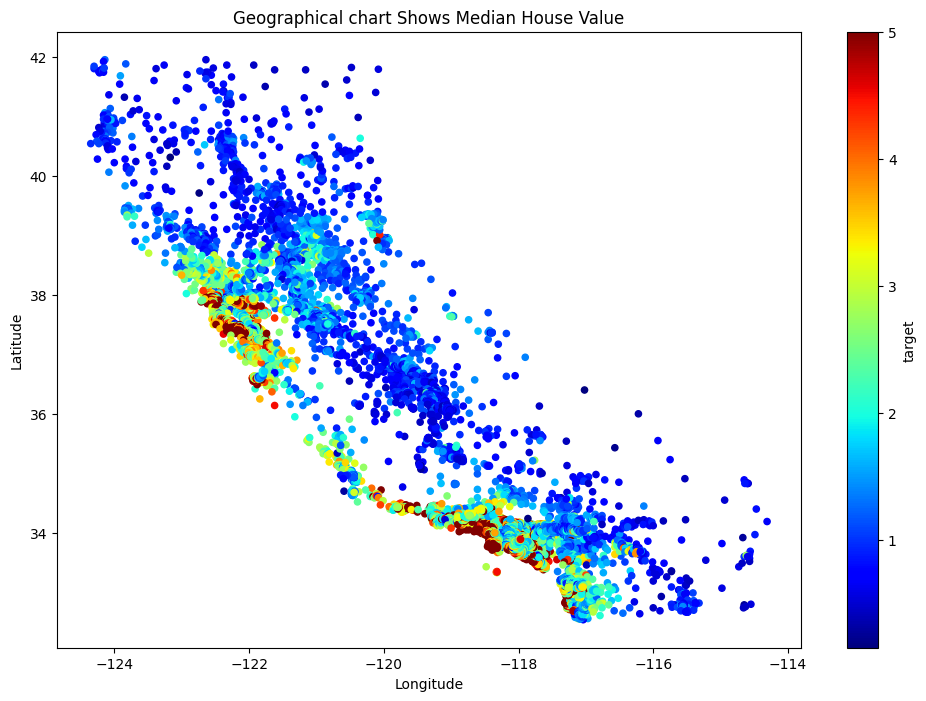

In [24]:
dataset.plot(kind="scatter", x='Longitude', y='Latitude', figsize=(12, 8),
           c="target", cmap=plt.get_cmap("jet"), colorbar=True, )
plt.title("Geographical chart Shows Median House Value")

We can choose to specify a different strategy for the creation of bins.
For instance, we can use the `decile` strategy.

In [25]:
new_explainer = LimeTabularExplainer(training_data=train_x, feature_names=housing.feature_names, class_names=['target'], random_state=SEED, mode='regression', discretizer='decile')


In [26]:
new_exp = new_explainer.explain_instance(data_row=test_x[INDEX], predict_fn=predictor.predict, num_features=5)
new_exp.as_list()

[('Longitude > -117.24', -0.5907749317906731),
 ('Latitude <= 33.62', 0.5325152810788021),
 ('2.33 < AveOccup <= 2.50', 0.13262710371989023),
 ('3.55 < MedInc <= 3.97', -0.13247279604195866),
 ('13.00 < HouseAge <= 17.00', -0.10335340127394403)]

Clearly, with a different strategy for the creation of bins, the explanation may change.
In this case, for the same record we obtain a different explanation.
The two most important features are again `Latitude` and `Longitude`, with different feature weights.
We also notice that `AveOccup` is present in the explanation instead of `AveRooms`.

In [ ]:
new_exp.show_in_notebook()
# new_exp.as_pyplot_figure()

<a id='classification'></a>
## Classification

<a id='classification-dataset'></a>
## Dataset description and analysis

The dataset used is the [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income) (also known as adult dataset).
The dataset is a collection of 48,842 records, each one representing an individual.
Each record contains 14 attributes, plus the class attribute, which is the one to be predicted.
The attributes are:
- `age`: numeric;
- `workclass`: categorical;
- `fnlwgt`: continuous (this is a metric computed upon a subset of the features, we can ignore it);
- `education`: categorical (duplicated information, we can ignore it);
- `education-num`: numeric;
- `marital-status`: categorical;
- `occupation`: categorical;
- `relationship`: categorical;
- `ethnicity`: categorical;
- `sex`: categorical;
- `capital-gain`: numeric;
- `capital-loss`: numeric;
- `hours-per-week`: numeric;
- `native-country`: categorical;

In [31]:
train_census = CensusIncome.get_train()
test_census = CensusIncome.get_test()

train_census

,Age,WorkClass,Fnlwgt,Education,EducationNumeric,MaritalStatus,Occupation,Relationship,Ethnicity,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


We drop the `fnlwgt` and `education` features.

In [32]:
train_census = train_census.drop(columns=['Fnlwgt', 'Education'])
test_census = test_census.drop(columns=['Fnlwgt', 'Education'])

In [33]:
train_census.describe()

,Age,EducationNumeric,CapitalGain,CapitalLoss,HoursPerWeek
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [34]:
feature_names = train_census.columns[:-1]
feature_names

Index(['Age', 'WorkClass', 'EducationNumeric', 'MaritalStatus', 'Occupation',
       'Relationship', 'Ethnicity', 'Sex', 'CapitalGain', 'CapitalLoss',
       'HoursPerWeek', 'NativeCountry'],
      dtype='object')

Because the dataset has categorical features, we need to encode them:
1. firstly, create a unique label for each different string value of a categorical feature;
2. then, we complete the process by applying a one-hot encoding.

We start by joining the training and test sets.
This is done because one of the two dataset may contain values that are not present in the other one and vice versa.

Class encoder.

In [35]:
data = pd.concat([train_census, test_census])
labels = data.iloc[:,12]
labels = labels.apply(lambda x: "<=50K" if x.replace(" ", "") in ("<=50K", "<=50K.") else ">50K").to_numpy()
le= LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data.to_numpy()
data = data[:, :-1]
class_names

array(['<=50K', '>50K'], dtype=object)

Features encoder.

In [36]:
categorical_features = [1,3,4,5,6,7,11]
categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data[:, feature])
    data[:, feature] = le.transform(data[:, feature])
    categorical_names[feature] = le.classes_

In [37]:
categorical_names

{1: array(['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private',
        'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
       dtype=object),
 3: array(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
       dtype=object),
 4: array(['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair',
        'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners',
        'Machine-op-inspct', 'Other-service', 'Priv-house-serv',
        'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support',
        'Transport-moving'], dtype=object),
 5: array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 6: array(['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other',
        'White'], dtype=object),
 7: array(['Female', 'Male'], dtype=object),
 11: array(['?', 'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba',
        'Dominican-Republic

In [38]:
data = data.astype(float)
encoder = ColumnTransformer([("enc", OneHotEncoder(), categorical_features)], remainder = 'passthrough')

In [39]:
train_x, train_y = data[:train_census.shape[0], :], labels[:train_census.shape[0]]
test_x, test_y = data[train_census.shape[0]:, :], labels[train_census.shape[0]:]

Encoding the dataset.

In [40]:
encoder.fit(data)
encoded_train_x = encoder.transform(train_x)
encoded_test_x = encoder.transform(test_x)

<a id='classification-training'></a>
### Training and evaluation

In [41]:
seed(SEED)
predictor = RandomForestClassifier()
predictor.fit(encoded_train_x, train_y)
y_pred = predictor.predict(encoded_test_x)
print(f"Accuracy {accuracy_score(test_y, y_pred)}")
print(f"F1 score {f1_score(test_y, y_pred)}")

Accuracy 0.8480437319574965
F1 score 0.6552396878483835


<a id='classification-explanation'></a>
### Explanation

In [43]:
for name, value in zip(train_census.columns[:-1], test_x[INDEX]):
    print(f"{name}: {value}")

Age: 51.0
WorkClass: 0.0
EducationNumeric: 10.0
MaritalStatus: 2.0
Occupation: 0.0
Relationship: 5.0
Ethnicity: 4.0
Sex: 0.0
CapitalGain: 0.0
CapitalLoss: 0.0
HoursPerWeek: 18.0
NativeCountry: 39.0


Note that we need to use predict_proba instead of predict for the explanation of a classification model.

In [44]:
predictor.predict_proba(encoded_test_x[INDEX])

array([[0.84, 0.16]])

In [45]:
explainer = LimeTabularExplainer(train_x ,feature_names = feature_names,class_names=class_names, categorical_features=categorical_features, categorical_names=categorical_names, random_state=SEED, mode='classification')

In [46]:
predict_fn = lambda x: predictor.predict_proba(encoder.transform(x))
exp = explainer.explain_instance(data_row=test_x[INDEX], predict_fn=predict_fn, num_features=5)

In [47]:
exp.show_in_notebook()
# exp.as_pyplot_figure()

In [48]:
exp.as_list()

[('CapitalGain <= 0.00', -0.5093996806934032),
 ('MaritalStatus=Married-civ-spouse', 0.11651899558268287),
 ('HoursPerWeek <= 40.00', -0.07595676731178111),
 ('Age > 48.00', 0.04762271910910225),
 ('Sex=Female', -0.04002626195034896)]